### Imports

In [1]:
import matplotlib.pyplot as plt
from fmpy import *
import numpy as np
import pandas as pd
import boto3
import json
import os
import glob

### Upload FMU files to S3 bucket
- BouncingBall.fmu - the FMU archive you want to simulate (must be compiled for linux64 platform or the simulation will fail)
- BouncingBall_pSets.json - the set of model parameters (values that are constant for each simulation loop)
- BouncingBall_iSet.json - the set of time series inputs for the model (time series interpolation)

In [2]:
# instantiate boto3 s3 client
s3_client = boto3.client('s3')
# upload the files (name of the local file, name of bucket, the name you want for the file in s3)
s3_client.upload_file('BouncingBall.fmu', 'fmpy-bucket', 'BouncingBall.fmu')
s3_client.upload_file('BouncingBall_pSets.json', 'fmpy-bucket', 'BouncingBall_pSets.json')
s3_client.upload_file('BouncingBall_iSet.json', 'fmpy-bucket', 'BouncingBall_iSet.json')

### Lambda inputs


https://hands-on.cloud/working-with-aws-lambda-in-python-using-boto3/#:~:text=To%20invoke%20the%20Lambda%20function,should%20contain%20JSON%20string%20data.
- Each parameter set defines 1 instance of the model
- If there are multiple parameter sets, can upload all at once (params, inputs, fmu file)
- Trigger lambdas based on those files
- Example: {
    'parameter_file': 'BouncingBall_pSets.json',
    'input_file': 'BouncingBall_iSet.json',
    'fmu_file': 'BouncingBall.fmu',
    'step_size': 0.01
}
- When invoking the Lambda, we can provide it some input data such as model start time, end time, and which json files to use. Note, all the inputs shown in the cell below are required for the simulation to run




The Lambda takes the following inputs:
- parameter_file: JSON file describing model parameter names and values (are constant for each simulation run)
- input_file: JSON file describing model input names and values (can be time series inputs)
- fmu_file: the name of the FMU file you want to simulate on S3
- start_time: simulation start time
- end_time: simulation end time
- index: used when a for loop invokes Lambdas in parallel (set index to 1 if only running one simulation)

In [3]:
# define data to send to lambda as inputs
lambda_client = boto3.client('lambda')
# all times are in seconds
simulate_event = {'parameter_file': 'BouncingBall_pSets.json',
    'input_file': 'BouncingBall_iSet.json',
    'fmu_file': 'BouncingBall.fmu',
    'start_time': 0,
    'end_time': 10,
    'step_size': 0.01,
    'index': 1}


### Invoke the Lambda
- Now we will invoke (trigger) one instance of the Lambda using the simulate_event inputs
- When finished, it will return the runtime, status code 200, and a success message
- If it failed, it will return the relevant error message
- Note, if you see a message about the simulation timing out or running out of memory, adjust the settings in the Lambda configuration page

In [4]:
# invoke the lambda with the input data using the payload argument
response = lambda_client.invoke(
  FunctionName='simulateCoupledClutches',
  Payload=json.dumps(simulate_event),
)
print(response['Payload'])
print(response['Payload'].read().decode("utf-8"))

{"runtime": "0.884697675704956 second(s)", "statusCode": 200, "body": "\"Ran successfully!\""}


### Download latest CSV file
- To plot the results, let's download the latest CSV file that was put into the S3 results bucket onto a local machine

In [5]:
# get the latest object from the s3 results bucket
fmu_name = 'BouncingBall'
def download_latest_file(fmu_name):
    s3_client = boto3.client('s3')
    response = s3_client.list_objects_v2(Bucket='simulate-fmu-results-bucket')
    objects = sorted(response['Contents'], key=lambda obj: obj['LastModified'])
    ## Latest object
    latest_object = objects[-1]['Key']
    filename = latest_object[latest_object.rfind('/')+1:] # Remove path
    # Download it to current directory
    s3_client.download_file('simulate-fmu-results-bucket', latest_object, filename)
    

In [6]:
download_latest_file(fmu_name)

In [7]:
list_of_files = glob.glob(fmu_name + '*.csv') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

BouncingBall.fmu_2022_07_13_03_31_47_.csv


### Plot the results
- Read data into Pandas dataframe
- Plot the variables with respect to time using matplotlib

In [52]:
# read the csv into a pandas dataframe
df = pd.read_csv(latest_file)
print(df)

       time    g         h      v
0      0.01 -9.8  0.999559 -0.098
1      0.02 -9.8  0.998138 -0.196
2      0.03 -9.8  0.995737 -0.294
3      0.04 -9.8  0.992356 -0.392
4      0.05 -9.8  0.987995 -0.490
...     ...  ...       ...    ...
996    9.97 -9.8  0.000000  0.000
997    9.98 -9.8  0.000000  0.000
998    9.99 -9.8  0.000000  0.000
999   10.00 -9.8  0.000000  0.000
1000  10.01 -9.8  0.000000  0.000

[1001 rows x 4 columns]


Text(0, 0.5, 'Gravity')

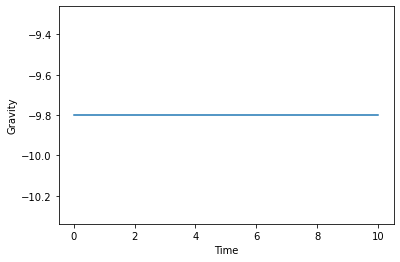

In [53]:
# plot inputs
plt.plot(df['time'],df['g'])
plt.xlabel("Time")
plt.ylabel("Gravity")

Text(0, 0.5, 'Height of ball')

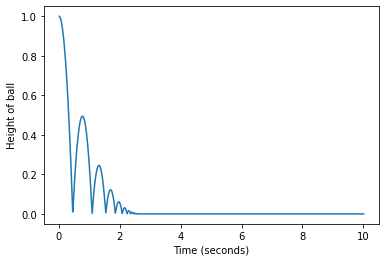

In [54]:
# plot outputs
plt.plot(df['time'],df['h'])
plt.xlabel("Time (seconds)")
plt.ylabel("Height of ball")

Text(0, 0.5, 'Velocity of ball (m/s)')

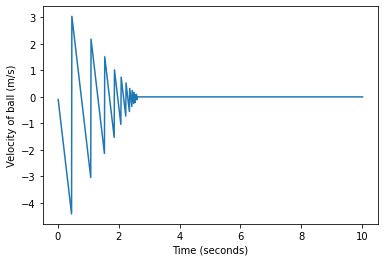

In [55]:
# velocity
plt.plot(df['time'],df['v'])
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity of ball (m/s)")

In [56]:
# print report of the simulation
list_of_files = glob.glob('*.txt') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)


BouncingBall.fmu2022_07_12_03_32_58.txt


### Simulate using a sweep of parameters
- Each pSets.json contains the parameters for a model (and only that model) for one simulation run.
- Let's say we want to simulate BouncingBall.fmu 10 times, but each time we change the gravity.
- So we need to create 10 pSets.json files and upload them to fmpy-bucket on S3
- By default, Python will wait for each Lambda execution to finish before starting the next one. However, this is slow so let's run them asynchronously (without waiting for a response).

In [192]:
s3_client.upload_file('BouncingBall.fmu', 'fmpy-bucket', 'BouncingBall.fmu')
s3_client.upload_file('BouncingBall_iSet.json', 'fmpy-bucket', 'BouncingBall_iSet.json')
# upload all 10 pSets
for i in range(10):
    j = str(i+1)
    pSets = 'BouncingBall_pSets_' + j + '.json'
    s3_client.upload_file(pSets, 'fmpy-bucket', pSets)


- Looping 10 times, each time increasing the input pSets file by 1 using an interator

In [232]:
# define data to send to lambda as inputs
lambda_client = boto3.client('lambda')

for i in range(10):
    # all times are in seconds
    # for iterating through the files
    j = str(i+1)
    pSets = 'BouncingBall_pSets_' + j + '.json'
    simulate_event = {'parameter_file': pSets,
        'input_file': 'BouncingBall_iSet.json',
        'fmu_file': 'BouncingBall.fmu',
        'start_time': 0,
        'end_time': 10,
        'threshold': 3,
        'step_size': 0.01,
        'index': j}
    # invoke the lambda with the input data using the payload argument
    # InvocationType - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/lambda.html#:~:text=To%20invoke%20a%20function%20asynchronously%2C%20set%20InvocationType%20to%20Event%20.
    response = lambda_client.invoke(
        FunctionName='simulateCoupledClutches',
        InvocationType='Event',
        Payload=json.dumps(simulate_event),
    )
    #print(response['Payload'])
    #print(response['Payload'].read().decode("utf-8"))
    


In [196]:
# plot results


### More complex model (with both inputs and parameters)
- DiscreteController.fmu
- The dump() function prints out model info

In [10]:
# print out model information
fmu_name = 'DiscreteController'
dump(fmu_name + '.fmu')


Model Info

  FMI Version        2.0
  FMI Type           Model Exchange
  Model Name         sb_DCMotor_Controller
  Description         
  Platforms          linux64
  Continuous States  3
  Event Indicators   0
  Variables          60
  Generation Tool    Activate
  Generation Date    2020-11-17T14:41:10Z

Default Experiment

  Stop Time          10.0
  Tolerance          1e-06
  Step Size          0.001

Variables (input, output)

  Name               Causality              Start Value  Unit     Description
  DCMotor_angle      output                                       index:57 ,output variable:SCSREAL_COP
  DCMotot_speed      output                                       index:58 ,output variable:SCSREAL_COP
  controller_output  output                                       index:59 ,output variable:SCSREAL_COP
  Reference_angle    input                          0.0           index:60 ,input variable:SCSREAL_COP


- Grabbing inputs and parameters to add to the JSON files

In [11]:
# print out all variables, including parameters
fmu_name = 'DiscreteController'
model_description = read_model_description(fmu_name + '.fmu')

vrs = {}
for variable in model_description.modelVariables:
    vrs[variable.name] = variable.valueReference
print('All parameters:', vrs)

All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2': 5, '

- Need to replace single quotes with double quotes, otherwise the Lambda won't be able to read the JSON

In [12]:
# create iSet and pSets files with example values
discrete_iset = str({"Reference_angle": 5})
discrete_pset = str({})
discrete_iset = discrete_iset.replace("\'", "\"")
discrete_pset = discrete_pset.replace("\'", "\"")
# write to new json files
with open(fmu_name + '_pSets.json', 'w') as f:
    f.write(str(discrete_pset))
with open(fmu_name + '_iSet.json', 'w') as f:
    f.write(str(discrete_iset))

- Uploading new files to S3

In [13]:
# upload to S3
s3_client.upload_file(fmu_name + '.fmu', 'fmpy-bucket', fmu_name + '.fmu')
s3_client.upload_file(fmu_name + '_iSet.json', 'fmpy-bucket', fmu_name + '_iSet.json')
s3_client.upload_file(fmu_name + '_pSets.json', 'fmpy-bucket', fmu_name + '_pSets.json')


- Running the simulation

In [14]:
simulate_event = {'parameter_file': fmu_name + '_pSets.json',
        'input_file': fmu_name + '_iSet.json',
        'fmu_file': fmu_name + '.fmu',
        'start_time': 0,
        'end_time': 10,
        'threshold': 3,
        'step_size': 0.01,
        'index': 1}


In [15]:
response = lambda_client.invoke(
        FunctionName='simulateCoupledClutches',
        #InvocationType='Event',
        Payload=json.dumps(simulate_event),
    )
print(response['Payload'])
print(response['Payload'].read().decode("utf-8"))

{"runtime": "0.9271504878997803 second(s)", "statusCode": 200, "body": "\"Ran successfully!\""}


- Download results and plot 

In [ ]:
fmu_name = 'DiscreteController'
download_latest_file(fmu_name)
# print report of the simulation
list_of_files = glob.glob('*.csv') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

In [17]:
# read the csv into a pandas dataframe
print(latest_file)
df2 = pd.read_csv(latest_file)
print(df2)

DiscreteController.fmu_2022_07_12_19_29_29_.csv
       time  Reference_angle  DCMotor_angle  DCMotot_speed  controller_output
0      0.01              5.0       0.000529       0.196136        2250.000000
1      0.02              5.0       0.003830       0.407689       -2205.237960
2      0.03              5.0       0.008248       0.561409        2210.272783
3      0.04              5.0       0.015036       0.741346       -2081.998207
4      0.05              5.0       0.022702       0.873604        2148.129703
...     ...              ...            ...            ...                ...
996    9.97              5.0       5.000254       0.000107          -0.004472
997    9.98              5.0       5.000255       0.000096          -0.004482
998    9.99              5.0       5.000256       0.000086          -0.004475
999   10.00              5.0       5.000257       0.000075          -0.004481
1000  10.01              5.0       5.000257       0.000065          -0.004472

[1001 rows x 5 

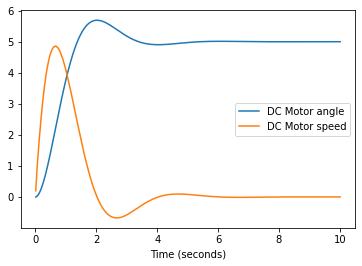

In [18]:
plt.plot(df2['time'], df2['DCMotor_angle'], label="DC Motor angle")
plt.plot(df2['time'], df2['DCMotot_speed'], label="DC Motor speed")
plt.xlabel('Time (seconds)')
plt.legend()

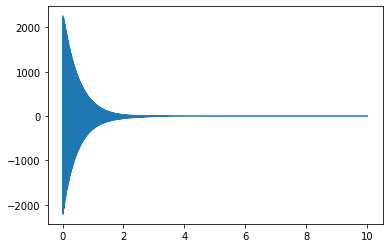

In [19]:
plt.plot(df2['time'], df2['controller_output'])

In [ ]:
# still need to plot RTF
# thesis discussion
# speed differences
# create true high fidelity digital twins
# decision making logic and physics
# mission planner will invoke the lambda
# can write model in any language
# FMI is kinda annoying